From `Experiment_before_P1.ipynb` we are starting with Entropy Acquisition function, and then perform continous training of active learning in `DemoP2.ipynb`

In [1]:
# @title Import libraries
import wget
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import warnings

import glob

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw

import torch
import torch.nn as nn
tt = torch.tensor
from math import log
import matplotlib.pyplot as plt
from pandas import json_normalize
from scipy.spatial import distance

import selfies as sf
import gpax
import atomai as aoi

import jax.numpy as jnp
gpax.utils.enable_x64()


from utils.helper_functions import *

import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import pearsonr

In [2]:
git_link = "https://github.com/aghosh92/DKLActiveLearnMol/blob/main/datasets/dataset0_5k.csv?raw=true"
df = pd.read_csv(git_link, index_col=0)
df.head()

,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,rotatablebd,...,stereocent,dipole_moment,enthalpy,internal_energy,internal_energy_zero,free_energy,homo,lumo,gap,zero_point_vib_energy
80704,OCC(C#C)C#CC#C,-0.1353,20.23,118.041865,1,1,"(44,)",0.104838,-0.394070,1,...,1,1.0110,-383.379422,-383.380366,-383.390139,-383.425247,-0.2487,-0.0227,0.2260,0.109023
65243,OC1C2NC1(C#C)C2O,-1.9344,52.49,125.047678,3,3,"(48,)",0.135711,-0.388302,0,...,2,2.9389,-437.764349,-437.765293,-437.773455,-437.805879,-0.2457,0.0183,0.2640,0.123328
127044,C1C2C3CC(CCO3)N12,0.2318,12.24,125.084064,0,2,"(50,)",0.075724,-0.376416,0,...,4,1.2046,-403.111686,-403.112630,-403.119162,-403.149575,-0.2233,0.0819,0.3052,0.175386
78132,CC1=CC2CC(O2)C1O,0.4647,29.46,126.068080,1,2,"(50,)",0.101096,-0.386045,0,...,3,2.0914,-423.006427,-423.007371,-423.015176,-423.047111,-0.2388,0.0018,0.2405,0.160473
90425,CC1CC1(O)CCC=O,0.7364,37.30,128.083730,1,2,"(52,)",0.119600,-0.389588,3,...,2,2.1074,-424.213274,-424.214219,-424.224729,-424.261135,-0.2481,-0.0208,0.2273,0.178994


Docker Initialization ---> Please insta,, docker before if haven't done already

Initialize docker with any specific name, assign port 7474 for Neo4j Broswer and Port 7687 for bolt. 

Please access the neo4j through `http://localhost:7474/Browser` to access the GraphDB, Specify the username and password for Bolt login

In [3]:
!docker stop vidkl
!docker rm vidkl

!docker run --name vidkl --rm -p7687:7687 -p7474:7474 -d -v $HOME/neo4j/data:/data -v $HOME/neo4j/logs:/logs -v $HOME/neo4j/import:/var/lib/neo4j/import -v $HOME/neo4j/plugins:/plugins --env NEO4J_AUTH=neo4j/test1234 neo4j:latest

/lustre/saranath/miniconda3/envs/vaedkl/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


vidkl
Error response from daemon: No such container: vidkl
4f5adaaa68dbe5949743ea4285ebd731f2b60c077dd2784d4ac788569bd5e43b


In [4]:
!cmf init local --path /lustre/saranath/Techcon24/viDKL/ \
--git-remote-url https://github.com/g3saranath/DKLActiveLearnMol \
--cmf-server-url http://0.0.0.0:8080 \
--neo4j-user neo4j --neo4j-password test1234 --neo4j-uri bolt://localhost:7687

git_dir /lustre/saranath/Techcon24/viDKL/.git
Starting cmf init.
Setting 'local-storage' as a default remote.
cmf init complete.


In [32]:
from cmflib.cmf import Cmf
from ml_metadata.proto import metadata_store_pb2 as mlpb 

graph = True 

metawriter = Cmf(
    filename="vidkl",
    pipeline_name="vidkl",
    graph = graph
)

*** Note: CMF will check out a new branch in git to commit the metadata files ***
*** The checked out branch is vidkl. ***


## Training Stage

In [33]:
selfies_dataset = []
error_smiles = []

# Assuming 'smiles' is the column in df containing SMILES strings
# Replace 'smiles' with the actual column name if it's different
for i, row in df.iterrows():
    try:
        local_sf = sf.encoder(row['smiles'])
        selfies_dataset.append(local_sf)
    except Exception as e:
        print(f"Error encoding SMILES at index {i}: {e}")
        error_smiles.append(row['smiles'])  # Store the SMILES string that caused the error
        continue  # Skip to the next iteration

#for producing corresponding one-hot vectors
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
alphabet.add("[nop]")  # [nop] is a special padding symbol
alphabet = list(sorted(alphabet))

length_list = []
for s in selfies_dataset:
  length = sf.len_selfies(s)
  length_list.append(length)
length_list.sort()
pad_to_len = length_list[-1]

symbol_to_idx = {s: i for i, s in enumerate(alphabet)}

labels = []
one_hot_vectors = []
for i in range(len(selfies_dataset)):

  label, one_hot = sf.selfies_to_encoding(selfies=selfies_dataset[i], vocab_stoi=symbol_to_idx,
                                          pad_to_len=pad_to_len, enc_type="both")
  labels.append(label)
  one_hot_vectors.append(one_hot)

molecules = np.array(one_hot_vectors)
s1, s2, s3 = molecules.shape
X = np.asarray(molecules).reshape([-1,s2*s3])
np.save("DKL/endoded_data.npy",X)
print(X.shape)

(5000, 567)


In [34]:
#Different targets
targets1 = df['ringct'].values
targets2 = df['mole_logp'].values
targets3 = df['mol_wt'].values
targets4 = df['dipole_moment'].values

Creating Context Stage - Training

In [35]:
context_stage1 = metawriter.create_context(pipeline_stage="Training",
                                          custom_properties={"Symbols":symbol_to_idx,
                                                            "Data_size":X.shape})

`gpax.utils.get_keys()` throws an I/O error, please run the cell again

In [10]:
X1 = np.copy(X)
X1 = X1[:1000]

## Target: ringct
targets1 = targets1[:1000]

#Saving the input and target values
np.save("DKL/train_data.npy",np.array(X1))
np.save("DKL/target_data.npy",np.array(targets1))

#Train the DKL model
rng_key_1, rng_key_predict_1 = gpax.utils.get_keys()

dkl_1 = gpax.viDKL(s2*s3, 2, 'RBF')
dkl_1.fit(rng_key_1, X1, targets1)
loss = dkl_1.loss

#Saving the MLL loss to log as metrics
np.save("DKL/loss_dkl_1.npy",np.array(loss))


Inferred GP kernel parameters
k_length         [1.3033 1.0485]
k_scale          4.1401
noise            0.0165


In [36]:
import jax.numpy as jnp
import jax

# Assuming params_dict is a dictionary with keys of type str and values of type jnp.ndarray
def save_params_dict(params_dict, filename):
    with open(filename, 'wb') as f:
        jnp.save(filename, params_dict)
    f.close()

In [37]:
# Saving Model Parameters --> MLP + Kernel:

# Getting the MLP and kernel params to reinitialize the model
nn, kernel = dkl_1.get_samples() # Returns the kernel and nn parameters


save_params_dict(kernel,"DKL/dkl1_kernel_params.npy")
save_params_dict(nn, "DKL/dkl1_nn_params_dict.npy")

Creating Execution Step for the Training Stage

In [38]:
execution_stage1 = metawriter.create_execution(execution_type="TrainviDKL",
                                               custom_properties={"Kernel_Name":f"{dkl_1.kernel_name}",
                                                                  "Kernel_Dimension":f"{dkl_1.kernel_dim}",
                                                                  "Guide_type":dkl_1.guide_type})

Logging Artifacts from Training Stage

In [39]:
#Input data
_ = metawriter.log_dataset("DKL/train_data.npy","input")

_ = metawriter.log_dataset("DKL/target_data.npy","input")

#Output Model
_ = metawriter.log_model("DKL/dkl1_kernel_params.npy","output",model_framework="haiku_and_jax",model_name="kernel_params")
_ = metawriter.log_model("DKL/dkl1_nn_params_dict.npy","output",model_framework="haiku_and_jax",model_name="nn_params")

# Step - Metrics / Loss
for ls in loss:
    metawriter.log_metric("training_metrics",{"training_loss":float(ls)}) #Loss is originally jnp array, but has to be converted to float for logging in CMF, as it throws an error when logged as jnp.ndarray
_ = metawriter.commit_metrics("training_metrics")

## Prediction Stage

In [40]:
batch_size_reconstruct = 250
embeded_1 = dkl_1.embed(X1)
pred_mean1, pred_var1 = dkl_1.predict_in_batches(rng_key_predict_1, X1, batch_size=batch_size_reconstruct)
pred_std1 = jnp.sqrt(pred_var1)

Saving the parameters from Predict Stage

In [16]:
np.save("DKL/embedding.npy", np.array(embeded_1))
np.save("DKL/predicted_mean.npy",np.array(pred_mean1))
np.save("DKL/predicted_unc.npy",np.array(pred_var1))
np.save("DKL/prediccted_std.npy",np.array(pred_std1))

Creating Context Stage for Prediction

In [41]:
context_stage1 = metawriter.create_context(pipeline_stage="Predict",
                                          custom_properties={"Symbols":symbol_to_idx,
                                                            "Data_size":(X.shape)})
execution_stage1 = metawriter.create_execution(execution_type="PredictviDKL",
                                              custom_properties={
                                                                "Kernel_Name":dkl_1.kernel_name,
                                                                "Kernel_Dimension":dkl_1.kernel_dim,
                                                                "Guide_type":dkl_1.guide_type,
                                                                "Batch_Size":batch_size_reconstruct})

Logging I/O from Predict Stage

In [42]:
## Output datasets
_ = metawriter.log_dataset("DKL/embedding.npy","output")

_ = metawriter.log_dataset("DKL/prediccted_std.npy","output")
_ = metawriter.log_dataset("DKL/predicted_mean.npy","output")
_ = metawriter.log_dataset("DKL/predicted_unc.npy","output")

"""Please log the above as metrics, Currently logged as Datasets as metrics doesn't support numpy file in CMF"""

#input training data
_ = metawriter.log_dataset("DKL/train_data.npy","input")

#Input trained model
_ = metawriter.log_model("DKL/dkl1_nn_params_dict.npy","input",model_framework="haiku_and_jax",model_name="nn_params")
_ = metawriter.log_model("DKL/dkl1_kernel_params.npy","input",model_framework="haiku_and_jax",model_name="kernel_params")



## Active Learning

In [43]:
X1 = np.copy(X)
X1 = X1[:1000]
#target
targets1 = - df['enthalpy'].values

targets1 = targets1[:1000]
target_property = "enthalpy"
acquisition_function = "UCB"


np.save("DKL/X_al.npy",np.array(X1))
np.save("DKL/trgt_enthalpy_al.npy",np.array(targets1))

#Active learning setup parameters
init_num = 50
exp_step = 50
batch_size_learn = 50 #make it 100 if start with 100 seed
batch_size_reconstruct = 250

Creating Context Stage for Active Learning

In [44]:
context_stage2 = metawriter.create_context(pipeline_stage="Active Learning",
                                          custom_properties={"Number_of_training_points":init_num,
                                                             "Target_property":target_property,
                                                             "Acquisition_function":acquisition_function,
                                                            "Total_Data_size":X1.shape,
                                                            "Exploration_Steps":exp_step,
                                                            "Batch_size":batch_size_learn,
                                                            "Batch_size_reconstruct":batch_size_reconstruct})

In [45]:
np.random.seed(0)
idx1 = np.random.choice(np.arange(len(X1)), size = init_num, replace = False)
X1_train = X1[idx1]
X1_unmeasured = np.delete(X1, idx1, axis=0)

indices_total_1 = np.arange(len(X))
indices_train_1 = indices_total_1[idx1]

y1_train = targets1[idx1]
y1_unmeasured = np.delete(targets1, idx1, axis=0)

indices_unmeasured_1 = np.delete(indices_total_1, idx1)

np.save("DKL/active_train_0.npy",np.array(X1_train))
np.save("DKL/X_unmeasured_al.npy",np.array(X1_unmeasured))

np.save("DKL/indices_train_al.npy",np.array(indices_train_1))
np.save("DKL/indices_unmeasured_al.npy",np.array(indices_unmeasured_1))

np.save("DKL/active_trgt_0.npy",np.array(y1_train))

Execution Step

In [46]:
execution_stage2 = metawriter.create_execution(execution_type="Active Learning",
                                        custom_properties={"Number_of_training_points":init_num,
                                                           "Exploration_Steps":exp_step,
                                                           "Train_size":(X1_train.shape),
                                                           "Unmeasured_size":(X1_unmeasured.shape),
                                                           "indices_selected":idx1,
                                                          "Target_property":target_property,
                                                          "Acquisition_function":acquisition_function})

Logging I/O from initial active learning step

In [47]:
# Input data selected for AL
_ = metawriter.log_dataset("DKL/X_al.npy","input")
_ = metawriter.log_dataset("DKL/trgt_enthalpy_al.npy","input")

# After sampling init samples for training and remaining for test
_ = metawriter.log_dataset("DKL/active_train_0.npy","output")
_ = metawriter.log_dataset("DKL/active_trgt_0.npy","output")


In [48]:
np.save(f"DKL/active_train_0_{acquisition_function}.npy",np.array(X1_train))
np.save(f"DKL/active_trgt_0_{acquisition_function}.npy",np.array(y1_train))

For the demo, showing the Active Learning being trained with one Acquisition Function `LCB`. The `DemoP2` will show continous training with another Acquisition Function  `Entropy` based on our observations from `Experiments_before_P1 `

In [24]:
from scipy.stats import pearsonr

exp_mean1, exp_std1 = [], []
dkl_mean1, dkl_std1 = [], []
embed_traj1 = []
traj_mean1, traj_std1 = [], []
objective_func = []

exploration_steps = exp_step

train_loss = []
test_loss = []
pearson_coeff = []

for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key11, rng_key_predict11 = gpax.utils.get_keys()
    dkl_BO_1 = gpax.viDKL(s2*s3, 2, 'RBF')
    if e == 0:
        nn,kernel = dkl_BO_1.get_samples()
        save_params_dict(nn,f"DKL/active_learning_nn_model_{e}_{acquisition_function}.npy")
        save_params_dict(kernel,f"DKL/active_learning_kernel_model_{e}_{acquisition_function}.npy")
        
    
    dkl_BO_1.fit(rng_key11, X1_train, y1_train)
   
    nn,kernel = dkl_BO_1.get_samples()
    save_params_dict(nn,f"DKL/active_learning_nn_model_{e+1}_{acquisition_function}.npy")
    save_params_dict(kernel,f"DKL/active_learning_kernel_model_{e+1}_{acquisition_function}.npy")
    
    # Compute acqusition function
    
    y_mean, y_var = dkl_BO_1.predict_in_batches(#make prediction batch-by-batch to avoid memory overflow
            rng_key_predict11, X1_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    
    y_mean_t, y_var_t = dkl_BO_1.predict_in_batches(#make prediction batch-by-batch to avoid memory overflow
            rng_key_predict11, X1_train, batch_size=50)
    
    loss_fcn = torch.nn.MSELoss()
    y_tl, y1_tl = np.asarray(y_mean_t), np.asarray(y1_train)
    y_tsl, y1_tsl = np.asarray(y_mean), np.asarray(y1_unmeasured)
    
    train_loss.append(np.mean(np.square(y_tl - y1_tl)))
    test_loss.append(np.mean(np.square(y_tsl - y1_tsl)))#loss_fcn(measured_spectrum,predicted_spectrum)
    correlation_coefficient, _ = pearsonr(y1_tsl, y_tsl)
    pearson_coeff.append(correlation_coefficient)
    print(f"Train Loss: {train_loss[-1]}")
    print(f"Test Loss: {test_loss[-1]}")
    print(f"Pearson Coeff: {correlation_coefficient}")
    
    obj = upper_confidence_bound(y_mean,y_std) #expected_improvement
    objective_func.append(obj)
    #np.save(f"VAEDKL_logs/object_{e+1}.npy",np.array(obj))
    # Get the next point to evaluate
    id_next = obj.argmax()
    np.save(f"DKL/next_pt_{e+1}_{acquisition_function}.npy",np.array(id_next))

    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean1.append(y_mean[id_next])
    exp_std1.append(y_std[id_next])

    x_next = X1_unmeasured[id_next]
    ind_next = indices_unmeasured_1[id_next]

    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean1.append(pred_mean1[ind_next])
    dkl_std1.append(pred_std1[ind_next])

    # Perform evaluation
    y_measured = targets1[ind_next]

    # Update training arrays
    X1_train = np.append(X1_train, x_next[None], axis=0)
    y1_train = np.append(y1_train, y_measured)
    X1_unmeasured = np.delete(X1_unmeasured, id_next, axis=0)
    y1_unmeasured = np.delete(y1_unmeasured, id_next, axis=0)
    
    indices_unmeasured_1 = np.delete(indices_unmeasured_1, id_next)

    np.save(f"DKL/active_train_{e+1}_{acquisition_function}.npy", np.array(X1_train))
    np.save(f"DKL/active_trgt_{e+1}_{acquisition_function}.npy", np.array(y1_train))
    
    embed_traj = dkl_BO_1.embed(X1_train)
    traj_m, traj_s = dkl_BO_1.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict11, X1_train, batch_size=batch_size_learn)

    np.save(f"DKL/embed_traj_{e+1}_{acquisition_function}.npy",np.array(embed_traj))
    
    embed_traj1.append(embed_traj)
    traj_mean1.append(traj_m)
    traj_std1.append(traj_s)


Step 1

Inferred GP kernel parameters
k_length         [1.4005 0.9728]
k_scale          6.2304
noise            2.3708
Train Loss: 169.10342383871767
Test Loss: 41222.170855108205
Pearson Coeff: -0.028023893630656563

Step 2

Inferred GP kernel parameters
k_length         [1.4061 0.9697]
k_scale          6.236400000000001
noise            2.3471
Train Loss: 153.49269826402957
Test Loss: 41750.13571350207
Pearson Coeff: -0.06042766600153737

Step 3

Inferred GP kernel parameters
k_length         [1.4018 0.9692]
k_scale          6.2302
noise            2.3539000000000003
Train Loss: 153.57200715493107
Test Loss: 45518.706952321896
Pearson Coeff: -0.07719724237115615

Step 4

Inferred GP kernel parameters
k_length         [1.4208 0.9787]
k_scale          6.201300000000001
noise            2.3718
Train Loss: 144.77097606081918
Test Loss: 42331.89110921191
Pearson Coeff: -0.06740486787257778

Step 5

Inferred GP kernel parameters
k_length         [1.4208 0.9574]
k_scale          6.1771
noi

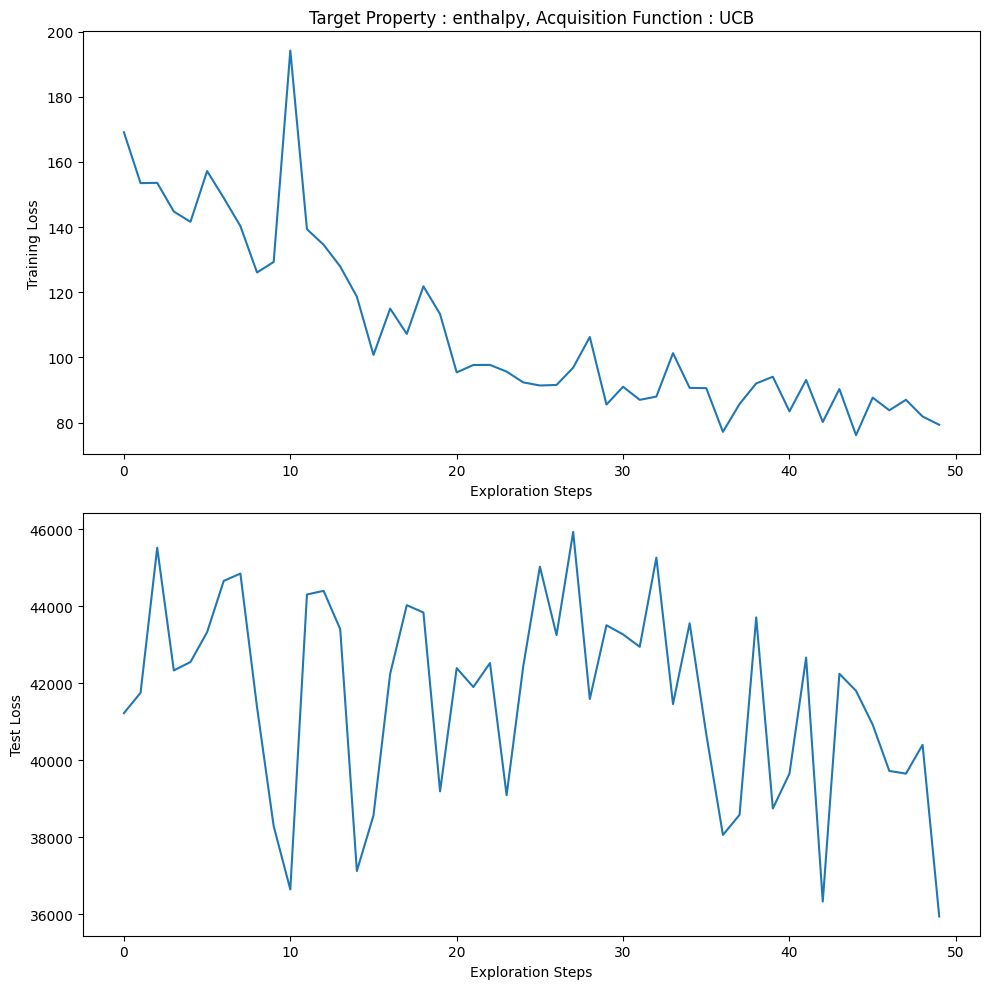

In [49]:
import matplotlib.pyplot as plt

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot Training Loss
axs[0].plot(train_loss) 
# Plot Test Loss
axs[1].plot(test_loss)


axs[0].set_title(f'Target Property : {target_property}, Acquisition Function : {acquisition_function}')
axs[0].set_xlabel('Exploration Steps')
axs[0].set_ylabel('Training Loss')

# axs[1].set_title('Test Loss')
axs[1].set_xlabel('Exploration Steps')
axs[1].set_ylabel('Test Loss')


plt.tight_layout()
plt.show()


Logging the Active Learning - 50 Exploration Stage for `UCB` Acquisition Function

In [ ]:
_ = metawriter.log_dataset("DKL/X_al.npy","input")
_ = metawriter.log_dataset("DKL/trgt_enthalpy_al.npy","input")

_ = metawriter.log_dataset(f"DKL/active_train_0_{acquisition_function}.npy","output")
_ = metawriter.log_dataset(f"DKL/active_trgt_0_{acquisition_function}.npy","output")


for e in range(exploration_steps):

    _ = metawriter.create_execution(execution_type=f"ActiveLearningTraining_{e}_exp", custom_properties={"Execution_Step":e,
                                                                                                      "Acquisition_function":f"{acquisition_function}",
                                                                                                         "Target_Property":f"{target_property}",
                                                                                                        "Training_loss":train_loss[e],
                                                                                                        "Test_Loss":test_loss[e],
                                                                                                        "Pearson_Coeff":pearson_coeff[e]})

    _ = metawriter.log_model(f"DKL/active_learning_nn_model_{e+1}_{acquisition_function}.npy","output",model_framework="mlp",model_name='nn_params')
    _ = metawriter.log_model(f"DKL/active_learning_kernel_model_{e+1}_{acquisition_function}.npy","input",model_framework="gpax",model_name='kernel_params')
    
    _ = metawriter.log_dataset(f"DKL/active_train_{e+1}_{acquisition_function}.npy","output")
    _ = metawriter.log_dataset(f"DKL/active_trgt_{e+1}_{acquisition_function}.npy","output")
    _ = metawriter.log_dataset(f"DKL/embed_traj_{e+1}_{acquisition_function}.npy","output")

    for obj in objective_func[e]:
        metawriter.log_metric(f"DKL/obj_funct{e}_val",{"obj_val":float(obj)})
    _ = metawriter.commit_metrics(f"DKL/obj_funct{e}_val")
    
    _ = metawriter.log_dataset(f"DKL/active_train_{e}_{acquisition_function}.npy","input")
    _ = metawriter.log_dataset(f"DKL/active_trgt_{e}_{acquisition_function}.npy","input")

    _ = metawriter.log_model(f"DKL/active_learning_nn_model_{e}_{acquisition_function}.npy","input",model_framework="mlp",model_name='nn_params')
    _ = metawriter.log_model(f"DKL/active_learning_kernel_model_{e}_{acquisition_function}.npy","input",model_framework="gpax",model_name='kernel_params')
_ = metawriter.log_execution_metrics("metrics", {"train_loss": train_loss, "test_loss": test_loss})

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


## Pushing CMF Artifacts and Metadata to the Server at 8080

In [27]:
import requests

def test_connection():
    url = "http://localhost:8080"  # URL to the cmf-server Docker container
    try:
        response = requests.get(url)  # Send a GET request
        if response.status_code == 200:
            print("Connection successful. Server is up and running.")
        else:
            print(f"Unexpected response code: {response.status_code}")
            print("Connection failed.")
    except requests.ConnectionError as e:
        print(f"Failed to establish connection: {e}")

# Call the function to test the connection
test_connection()

Connection successful. Server is up and running.


In [28]:
from cmflib import cmf
result = cmf.artifact_push()
result = cmf.metadata_push(pipeline_name="VIDKL", filename="vidkl")

313 files pushed
metadata push started
........................................
mlmd is successfully pushed.
